<a href="https://colab.research.google.com/github/lalith0203/StockPrice_Prediction/blob/main/StockPrice_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NSE-TATAGLOBAL.csv to NSE-TATAGLOBAL.csv


In [ ]:
df=pd.read_csv("NSE-TATAGLOBAL.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [ ]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-09-28,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


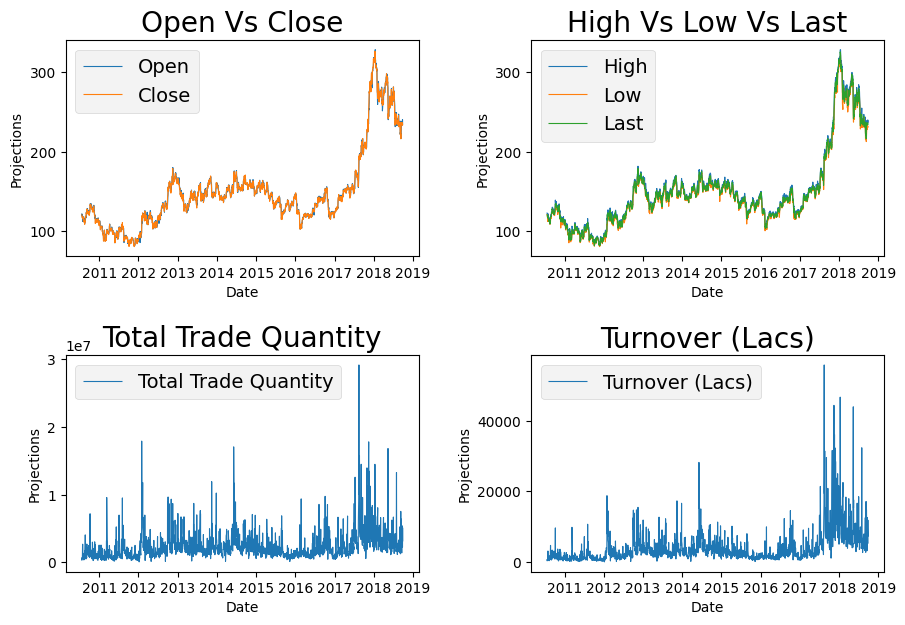

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 7), squeeze=False)
fig.tight_layout(pad=5)
plt.style.use('fivethirtyeight')
axes[0][0].plot(df["Open"],linewidth=0.8)
axes[0][0].plot(df["Close"],linewidth=0.8)
axes[0][0].set_ylabel("Projections")
axes[0][0].set_xlabel("Date")
axes[0][0].set_title('Open Vs Close')
axes[0][0].legend(['Open', 'Close'], loc='upper left')
axes[0][1].plot(df["High"],linewidth=0.8)
axes[0][1].plot(df["Low"],linewidth=0.8)
axes[0][1].plot(df["Last"],linewidth=0.8)
axes[0][1].set_ylabel("Projections")
axes[0][1].set_xlabel("Date")
axes[0][1].set_title('High Vs Low Vs Last')
axes[0][1].legend(['High', 'Low', 'Last'], loc='upper left')
axes[1][0].plot(df["Total Trade Quantity"],linewidth=0.8)
axes[1][0].set_ylabel("Projections")
axes[1][0].set_xlabel("Date")
axes[1][0].set_title('Total Trade Quantity')
axes[1][0].legend(['Total Trade Quantity'], loc='upper left')
axes[1][1].plot(df["Turnover (Lacs)"],linewidth=0.8)
axes[1][1].set_ylabel("Projections")
axes[1][1].set_xlabel("Date")
axes[1][1].set_title('Turnover (Lacs)')
axes[1][1].legend(['Turnover (Lacs)'], loc='upper left')

In [ ]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
 new_dataset["Date"][i]=data['Date'][i]
 new_dataset["Close"][i]=data["Close"][i]
new_dataset.head()

,Date,Close
0,2010-07-21 00:00:00,121.55
1,2010-07-22 00:00:00,120.9
2,2010-07-23 00:00:00,120.65
3,2010-07-26 00:00:00,117.6
4,2010-07-27 00:00:00,118.65


In [ ]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis='columns',inplace=True)
final_dataset=new_dataset.values
new_dataset.head()

,Close
Date,
2010-07-21,121.55
2010-07-22,120.9
2010-07-23,120.65
2010-07-26,117.6
2010-07-27,118.65


In [ ]:
df=new_dataset.reset_index()['Close']
print(df)

0       121.55
1        120.9
2       120.65
3        117.6
4       118.65
         ...  
2030     233.3
2031     236.1
2032    234.25
2033    233.25
2034    233.75
Name: Close, Length: 2035, dtype: object


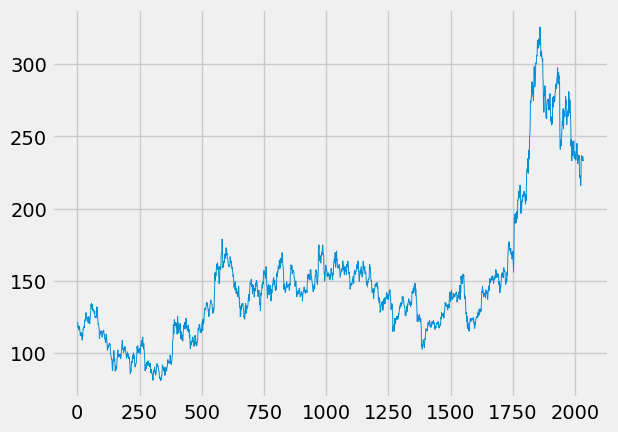

In [ ]:
plt.plot(df, linewidth=0.7)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))
print(df)

[[0.16584967]
 [0.16319444]
 [0.1621732 ]
 ...
 [0.62622549]
 [0.62214052]
 [0.62418301]]


In [ ]:
training_size=int(len(df)*0.65)
testing_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-time_step-1):
  a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3-----99 100
  dataX.append(a)
  dataY.append(dataset[i + time_step, 0])
 return numpy.array(dataX), numpy.array(dataY)
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)

(1221, 100)
(1221,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(612, 100)
(612,)


(None, None)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
39/39 [==============================] - 13s 180ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 2/100
39/39 [==============================] - 7s 174ms/step - loss: 9.1945e-04 - val_loss: 0.0035
Epoch 3/100
39/39 [==============================] - 6s 156ms/step - loss: 9.2358e-04 - val_loss: 0.0042
Epoch 4/100
39/39 [==============================] - 7s 173ms/step - loss: 8.6803e-04 - val_loss: 0.0037
Epoch 5/100
39/39 [==============================] - 6s 146ms/step - loss: 7.8115e-04 - val_loss: 0.0032
Epoch 6/100
39/39 [==============================] - 7s 174ms/step - loss: 7.6619e-04 - val_loss: 0.0038
Epoch 7/100
39/39 [==============================] - 6s 146ms/step - loss: 7.1044e-04 - val_loss: 0.0037
Epoch 8/100
39/39 [==============================] - 7s 174ms/step - loss: 6.5598e-04 - val_loss: 0.0051
Epoch 9/100
39/39 [==============================] - 6s 146ms/step - loss: 6.7390e-04 - val_loss: 0.0029
Epoch 10/100
39/39 [==============================] - 7s 1

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

20/20 [==============================] - 1s 36ms/step


Text(0.5, 1.0, 'Train Predictions')

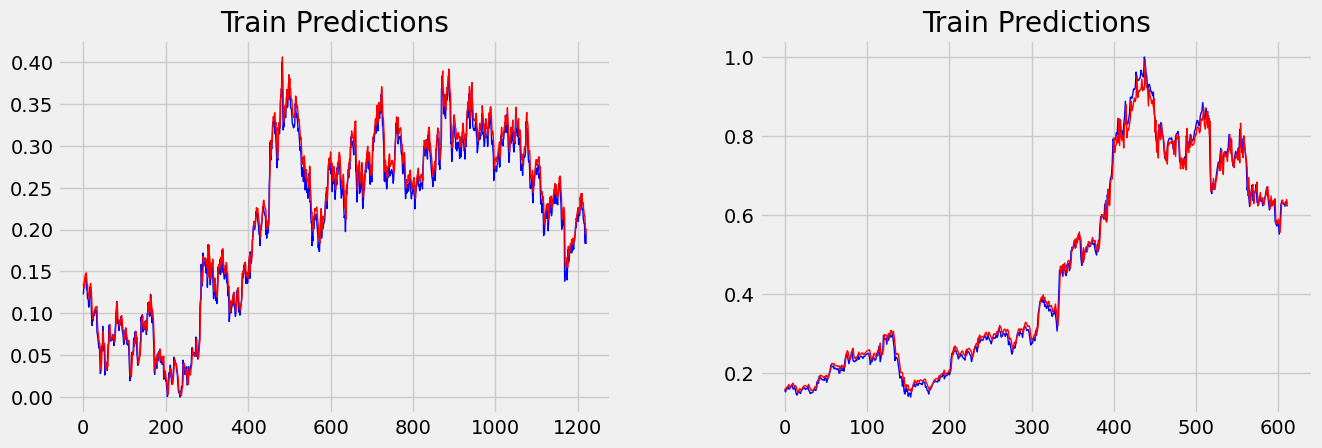

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15, 6), squeeze=False)
fig.tight_layout(pad=5)
plt.style.use('fivethirtyeight')
axes[0][0].plot(y_train,color='b',linewidth=1)
axes[0][0].plot(train_predict,color='r',linewidth=1)
axes[0][0].set_title('Train Predictions')
axes[0][1].plot(ytest,color='b',linewidth=1)
axes[0][1].plot(test_predict,color='r',linewidth=1)
axes[0][1].set_title('Train Predictions')

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
math.sqrt(mean_squared_error(y_train,train_predict))

136.28520629951547

In [ ]:
mae = mean_absolute_error(ytest,test_predict)
mse = mean_squared_error(ytest,test_predict)
r2 = r2_score(ytest,test_predict)
rmse = math.sqrt(mean_squared_error(ytest,test_predict))
print("The model performance for testing set:")
for i in range(38):
 print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 191.83494699003856
MSE is 40513.25501590285
R2 is -605638.7977860502
RMSE is 201.2790476326407


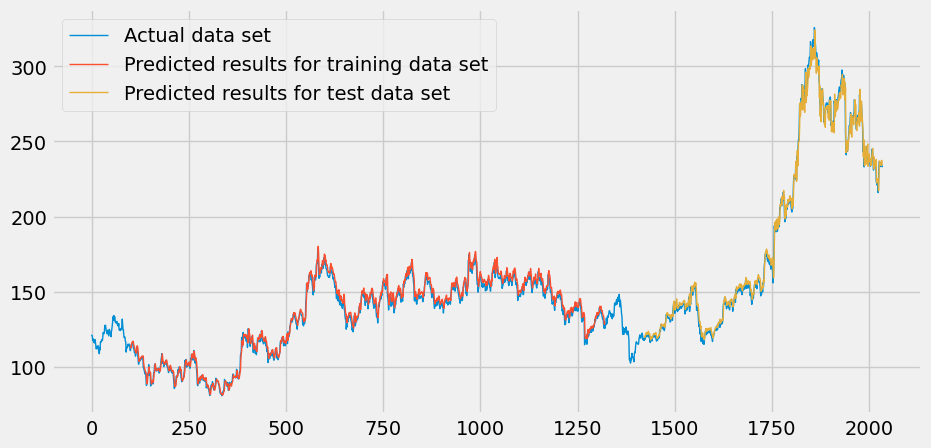

In [ ]:
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(df),linewidth=1)
plt.plot(trainPredictPlot,linewidth=1)
plt.plot(testPredictPlot,linewidth=1)
plt.legend(['Actual data set', 'Predicted results for training data set', 'Predicted results for test data set'])
plt.show()

In [ ]:
len(test_data)

713

In [ ]:
x_input=test_data[333:].reshape(1,-1)
x_input.shape

(1, 380)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
from numpy import array
lst_output=[]
n_steps=380
i=1
while(i<=30):
 if(len(temp_input)>100):
  x_input=np.array(temp_input[1:])
  print("{} day input: \n\n{}".format(i,x_input))
  x_input=x_input.reshape(1,-1)
  x_input = x_input.reshape((1, n_steps, 1))
  yhat = model.predict(x_input, verbose=0)
  print("\n{} day output: {}\n\n\n".format(i,yhat))
  temp_input.extend(yhat[0].tolist())
  temp_input=temp_input[1:]
  lst_output.extend(yhat.tolist())
  i=i+1
else:
 x_input = x_input.reshape((1, n_steps,1))
 yhat = model.predict(x_input, verbose=0)
 print(yhat[0])
 temp_input.extend(yhat[0].tolist())
 print(len(temp_input))
 lst_output.extend(yhat.tolist())
 i=i+1

1 day input: 

[0.29268791 0.29861111 0.30187908 0.29840686 0.29289216 0.30085784
 0.3002451  0.29370915 0.27185458 0.28002451 0.27308007 0.26062092
 0.24816176 0.25367647 0.26940359 0.26327614 0.26388889 0.27961601
 0.29187092 0.30187908 0.30228758 0.2943219  0.30473856 0.30085784
 0.30004085 0.29064542 0.30841503 0.31658497 0.3192402  0.31556373
 0.30821078 0.31004902 0.30984477 0.30147059 0.28676471 0.27124183
 0.27859477 0.27593954 0.28472222 0.28860294 0.28227124 0.30718954
 0.29575163 0.31372549 0.3496732  0.36172386 0.37908497 0.38582516
 0.3809232  0.39236111 0.37908497 0.38480392 0.3690768  0.37275327
 0.36376634 0.36846405 0.37275327 0.35723039 0.36029412 0.3619281
 0.35355392 0.34375    0.3500817  0.34926471 0.36560458 0.34742647
 0.3314951  0.3065768  0.34007353 0.3995098  0.46119281 0.44791667
 0.46343954 0.47058824 0.44485294 0.47222222 0.4628268  0.45894608
 0.44689542 0.47426471 0.47814542 0.47651144 0.45894608 0.47283497
 0.51062092 0.50980392 0.51450163 0.52410131 0.5

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,132)
len(df)

2035

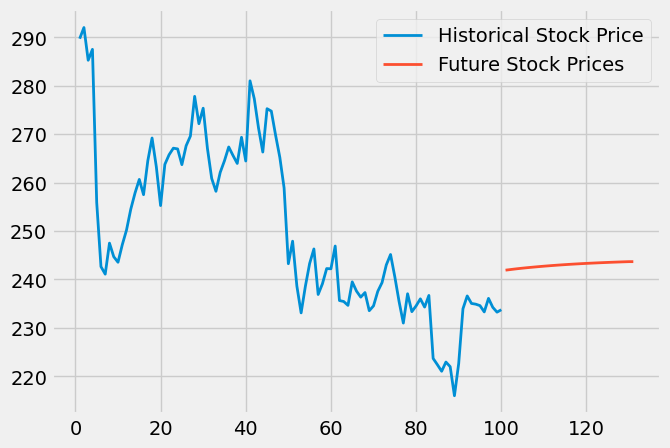

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(day_new, scaler.inverse_transform(df[1935:]), linewidth=2)
plt.plot(day_pred, scaler.inverse_transform(lst_output), linewidth=2)
plt.legend(['Historical Stock Price', 'Future Stock Prices'])
plt.show()